<font size="6px" font color="blue" face="Times New Roman"><b> Modelagem de perfis de poços</b></font>


In [1]:
#Pacotes
# -*- coding: utf-8 -*- 
%matplotlib notebook 

import numpy as np
import pylab as py
import scipy as sp
from scipy import signal
from scipy.signal import correlate
import matplotlib.pyplot as plt
import IPython as ipw
#-------------------------------------
#novos pacotes de imagem
import imageio
from skimage import data, io, filters 
#-------------------------------------
import sys

#pacotes de visualização de dados
import pandas as pd

#####
import random


In [2]:
# Importar pacotos externos:
sys.path.insert(0,'modules')

import noise as noi
import modeling 

In [3]:
# leitura da seção geologica:
ma = io.imread("entrada/Namorado_7.png", as_gray=False, pilmode="RGBA")


In [4]:
#### Conversão de coordenadas pixel para métrica

nx = np.shape(ma)[1] # Valores em pixel da imagem
nz = np.shape(ma)[0]

print(nx, nz)

xt = np.linspace(0, 4200, nx, endpoint=True) # O segundo campo do linsspace tem que ser a coordenada real da seção
zt = np.linspace(0, 170, nz, endpoint=True) # 4200 e 170 são dimensões da seção real.

print(xt, zt)

5189 2396
[0.00000000e+00 8.09560524e-01 1.61912105e+00 ... 4.19838088e+03
 4.19919044e+03 4.20000000e+03] [0.00000000e+00 7.09812109e-02 1.41962422e-01 ... 1.69858038e+02
 1.69929019e+02 1.70000000e+02]


<IPython.core.display.Javascript object>


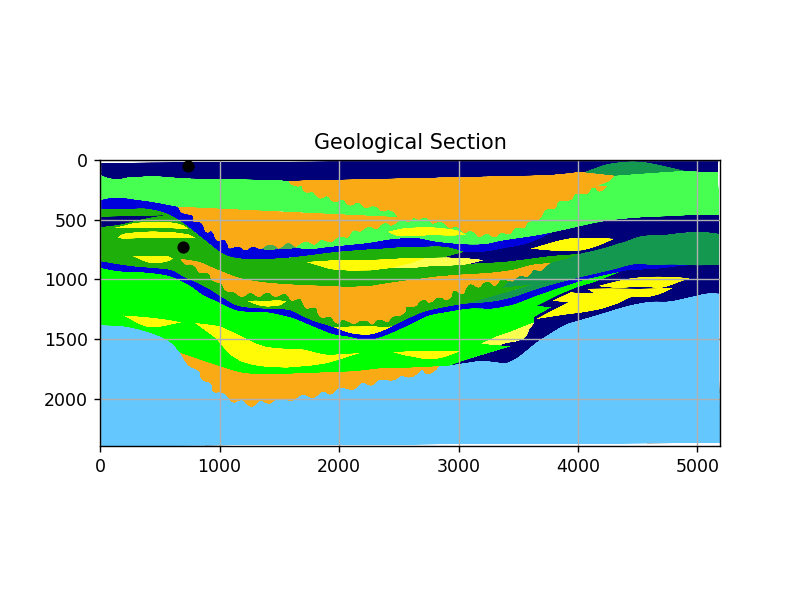

In [5]:
# leitura da seção geologica:

# funcao que perfura e salva as coordenadas de inicio e fim da perfuracao:
x,y = modeling.drilling(ma)

In [6]:
# Cotas para extrair do banco de cores da secao geologica:
cota_m = [xt[int(x[0])], zt[int(min(y))], zt[int(max(y))]] # Coordenadas convertidas em metros
cota_p = [int(x[0]), int(min(y)), int(max(y))] # Coordenadas em pixel (original)

# Criando e escrevendo em arquivos de texto (modo 'w'). Saída de dados do clique
#arquivo = open('../saida/cotas.txt','w')
#arquivo.write( str(cota_m[1]) )
#arquivo.write("  ")
#arquivo.write( str(cota_m[2]) )
#arquivo.write("  ")
#arquivo.write( str(cota_m[0]) )
#arquivo.close()

In [7]:
print(cota_m, cota_p)

[594.2174248265227, 3.336116910229645, 51.603340292275576] [734, 47, 727]


In [11]:
########################################### Etapa de codificação ##################################################

cab = ['n','R', 'G', 'B', 'A','Hex', 'Name']
data = pd.read_csv('entrada/geocodes.txt', sep='\s+',skiprows=1, names = cab )

#data = pd.read_csv('entrada/geocodes.txt', header = None)
data

,n,R,G,B,A,Hex,Name
0,0,20,152,80,255,#149850,folhelho1
1,1,70,255,80,255,#46FF50,folhelho2
2,2,30,175,10,255,#1EAF0A,folhelho3
3,3,0,255,0,255,#00FF00,folhelho4
4,4,255,250,5,255,#FFFA05,arenito1
5,5,250,255,80,255,#FAFF50,arenito2
6,6,250,170,20,255,#FAAA14,conglomerado
7,7,0,0,120,255,#000078,marga1
8,8,0,0,220,255,#0000DC,marga2
9,9,100,200,255,255,#64C8FF,calcarenito


In [12]:
########################### Teste para criação do dicionário "codigo" a partir do txt #######################################

# Cálculo das distâncias em RGBA
w1 = np.sqrt(data['R']**2 + data['G']**2 + data['B']**2 + data['A']**2) # Operação métrica com o arquivo RGBA

codigo1 = {a1_: [a2_, a3_, a4_, a5_, a6_, a7_, a8_] for a1_, a2_, a3_, a4_, a5_, a6_, a7_, a8_
           in zip(data['n'], data['R'], data['G'], data['B'], data['A'], w1, data['Hex'], data['Name'])}

#codigo1[0][6]

In [13]:
##################################### Cálculo das distâncias dos RGBA ##################################################
# definindo  

zmin=int(cota_p[1]) 
zmax=int(cota_p[2])
h=int(cota_p[0])

# Conversão de coordenadas pixel para métrica (do poço clicado)
mb = np.copy(ma[zmin:zmax, h, :]) #Faz uma amostragem vertical na seção. Essa amostragem simula o poço.
prof = np.linspace(cota_m[1], cota_m[2], np.size(mb,0), endpoint=True) 


# Calcula as distancias no espaco das cores do RGBA:
dist = np.zeros(np.size(mb,0))
for i in range(np.size(mb,0)):
    dist[i] = np.sqrt((mb[i,0]**2 + mb[i,1]**2 + mb[i,2]**2 + mb[i,3]**2))
    
#print(dist)

In [14]:
########## Tratando do bug nas transicoes entre as cores a partir do código criado pelo txt ###################
for i in range(np.size(mb,0)):
    if (dist[i] != codigo1[0][4] and dist[i] != codigo1[1][4] and dist[i] != codigo1[2][4] 
        and dist[i] != codigo1[3][4] and dist[i] != codigo1[4][4] and dist[i] != codigo1[5][4] 
        and dist[i] != codigo1[6][4] and dist[i] != codigo1[7][4]
        and dist[i] != codigo1[8][4] and dist[i] != codigo1[9][4]):
        dist[i] = dist[i-1]

#Todo: Automatizar o processo de captação do número de rocha da seção geológica.
#dist

In [15]:
### ---- # criacao do codigo de rocha para plot:     
nrocks = len(codigo1)
codrock = np.zeros(len(dist))
for i in range(len(dist)):
    for j in range(nrocks):
        if dist[i]==codigo1[j][4]:
            codrock[i]=j
            
codrock
### Obs: Adaptou-se a criação do código de rocha a partir do "codigo1" 

array([7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7.,
       7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7.,
       7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7.,
       7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7.,
       7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7.,
       7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7.,
       7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.

### Esta célula salva os codigos dos poços oriundos do click.

c = pd.DataFrame(codrock)

c.to_csv('../saida/poco_click_09-05.txt', index=False, sep= ' ')

In [16]:
# Guardando os codigos de rocha existentes no poco perfurado e montando as cores:

litos = [] # Nomes das rochas la do dicionário
rock_poco = [] # Código das rochas
hex_cores = [] # Cor Hex das rochas la do dicionário
r = [] # Cores RGB lá do dicionário
g = []
b = []
a = []

shale1 = { } # folhelho1
shale2 = { } # folhelho2
shale3 = { } # folhelho3
shale4 = { } # folhelho4
sands1 = { } # arenito1
sands2 = { } # arenito2
congl  = { } # conglomerado
marl1  = { } # marga1
marl2  = { } # marga2
calca  = { } # calcarenito

if np.any(codrock == 0):
    rock_poco.append(0)
    hex_cores.append(codigo1[0][5])
    litos.append(codigo1[0][6])
    r.append(codigo1[0][0])
    g.append(codigo1[0][1])
    b.append(codigo1[0][2])
    a.append(codigo1[0][3])
    shale1 = {'rock': 'folhelho1','rhob': 2.12, 'gr': 115.0, 'dt': 62.0, 'ild': 1e3}

if np.any(codrock == 1):
    rock_poco.append(1)
    hex_cores.append(codigo1[1][5])
    litos.append(codigo1[1][6])
    r.append(codigo1[1][0])
    g.append(codigo1[1][1])
    b.append(codigo1[1][2])
    a.append(codigo1[1][3])
    shale2 = {'rock': 'folhelho2','rhob': 2.25, 'gr': 75.0, 'dt': 167.0, 'ild': 1e1}

if np.any(codrock == 2):
    rock_poco.append(2)
    hex_cores.append(codigo1[2][5])
    litos.append(codigo1[2][6])
    r.append(codigo1[2][0])
    g.append(codigo1[2][1])
    b.append(codigo1[2][2])
    a.append(codigo1[2][3])
    shale3 = {'rock': 'folhelho3','rhob': 2.43, 'gr': 40.0, 'dt': 132.0, 'ild': 1e5}
    
if np.any(codrock == 3):
    rock_poco.append(3)
    hex_cores.append(codigo1[3][5])
    litos.append(codigo1[3][6])
    r.append(codigo1[3][0])
    g.append(codigo1[3][1])
    b.append(codigo1[3][2])
    a.append(codigo1[3][3])
    shale4 = {'rock': 'folhelho4','rhob': 1.8, 'gr': 140.0, 'dt': 97.0, 'ild': 1e4}
    
if np.any(codrock == 4):
    rock_poco.append(4)
    hex_cores.append(codigo1[4][5])
    litos.append(codigo1[4][6])
    r.append(codigo1[4][0])
    g.append(codigo1[4][1])
    b.append(codigo1[4][2])
    a.append(codigo1[4][3])
    sands1 = {'rock': 'arenito1','rhob': 1.9, 'gr': 20.0, 'dt': 70.0, 'ild': 1e1}
    
if np.any(codrock == 5):
    rock_poco.append(5)
    hex_cores.append(codigo1[5][5])
    litos.append(codigo1[5][6])
    r.append(codigo1[5][0])
    g.append(codigo1[5][1])
    b.append(codigo1[5][2])
    a.append(codigo1[5][3])
    sands2 = {'rock': 'arenito2','rhob': 2.40, 'gr': 37.0, 'dt': 80.0, 'ild': 1e8}

if np.any(codrock == 6):
    rock_poco.append(6)
    hex_cores.append(codigo1[6][5])
    litos.append(codigo1[6][6])
    r.append(codigo1[6][0])
    g.append(codigo1[6][1])
    b.append(codigo1[6][2])
    a.append(codigo1[6][3])
    congl = {'rock': 'conglomerado' ,'rhob': 2.55, 'gr': 22.0, 'dt': 60.0, 'ild': 1.20e4}
    
if np.any(codrock == 7):
    rock_poco.append(7)
    hex_cores.append(codigo1[7][5])
    litos.append(codigo1[7][6])
    r.append(codigo1[7][0])
    g.append(codigo1[7][1])
    b.append(codigo1[7][2])
    a.append(codigo1[7][3])
    marl1 = {'rock': 'marga1', 'rhob': 2.75, 'gr': 80.0, 'dt': 70.0, 'ild': 55.0}
    
if np.any(codrock == 8):
    rock_poco.append(8)
    hex_cores.append(codigo1[8][5])
    litos.append(codigo1[8][6])
    r.append(codigo1[8][0])
    g.append(codigo1[8][1])
    b.append(codigo1[8][2])
    a.append(codigo1[8][3])
    marl2 = {'rock':'marga2', 'rhob': 2.70, 'gr': 70.0, 'dt': 75.0, 'ild': 50.0}

    
if np.any(codrock == 9):
    rock_poco.append(9)
    hex_cores.append(codigo1[9][5])
    litos.append(codigo1[9][6])
    r.append(codigo1[9][0])
    g.append(codigo1[9][1])
    b.append(codigo1[9][2])
    a.append(codigo1[9][3])
    calca = {'rock': 'calcarenito', 'rhob': 2.45, 'gr': 7.5, 'dt': 80.0, 'ild': 3.50e2}
    

In [17]:
# definicao da uma lista com todos os dicionarios nao nulos:
listao = [shale1, shale2, shale3, shale4,
          sands1, sands2, congl, marl1, marl2, calca ]

centroides = []
for x in listao:
    if x!= {}:
        centroides.append(x)      
        

In [18]:
# Criação de uma variável "centroides" com os valores dos centroides para o K-means?!

centroides 

[{'rock': 'folhelho2', 'rhob': 2.25, 'gr': 75.0, 'dt': 167.0, 'ild': 10.0},
 {'rock': 'folhelho3', 'rhob': 2.43, 'gr': 40.0, 'dt': 132.0, 'ild': 100000.0},
 {'rock': 'arenito1', 'rhob': 1.9, 'gr': 20.0, 'dt': 70.0, 'ild': 10.0},
 {'rock': 'conglomerado',
  'rhob': 2.55,
  'gr': 22.0,
  'dt': 60.0,
  'ild': 12000.0},
 {'rock': 'marga1', 'rhob': 2.75, 'gr': 80.0, 'dt': 70.0, 'ild': 55.0},
 {'rock': 'marga2', 'rhob': 2.7, 'gr': 70.0, 'dt': 75.0, 'ild': 50.0}]

In [19]:
cent = pd.DataFrame(centroides)

cent.to_csv('../saida/centroides_poco_09-05.txt', index=False, sep= ' ')

In [20]:
cent

,rock,rhob,gr,dt,ild
0,folhelho2,2.25,75.0,167.0,10.0
1,folhelho3,2.43,40.0,132.0,100000.0
2,arenito1,1.90,20.0,70.0,10.0
3,conglomerado,2.55,22.0,60.0,12000.0
4,marga1,2.75,80.0,70.0,55.0
5,marga2,2.70,70.0,75.0,50.0


In [21]:
######### Dicionário com as litologias do perfil selecionado ############## 
dic = {a_: [b_, c_, d_, e_, f_, g_] for a_, b_, c_, d_, e_, f_, g_ in zip(rock_poco, hex_cores, litos, r, g, b, a)}
dic

{1: ['#46FF50', 'folhelho2', 70, 255, 80, 255],
 2: ['#1EAF0A', 'folhelho3', 30, 175, 10, 255],
 4: ['#FFFA05', 'arenito1', 255, 250, 5, 255],
 6: ['#FAAA14', 'conglomerado', 250, 170, 20, 255],
 7: ['#000078', 'marga1', 0, 0, 120, 255],
 8: ['#0000DC', 'marga2', 0, 0, 220, 255]}

### Salvar dicionário na saída:
df_dic = pd.DataFrame(dic)
d = df_dic.T
d.loc[:, 'cod'] = rock_poco # indexando o código de rocha ao dicionário

print(d)
d.to_csv('../saida/dicionario_click_poco_09-05.txt', index=False, sep= ' ')

###  PERFILAGEM 


In [22]:
############################################### DENSIDADE ###################################################
############################################### RAIO-GAMMA ##################################################
############################################## RESISTIVIDADE ################################################
################################################ SÔNICO #####################################################

RHOmb = [0.0]*np.size(mb,0)
GRmb = [0.0]*np.size(mb,0)
Rmb = [0.0]*np.size(mb,0)
Smb = [0.0]*np.size(mb,0)
lito = [0.0]*np.size(mb,0)
#prof = []*np.size(mb,0) #cria um vetor vazio

for i in range(np.size(mb,0)): # Cria um Laço com índice i que varia de 0 até o tamanho de mb menos 1. 
    if dist[i] == codigo1[0][4]:     #declara que quando o índice i for igual a 0 na posição mn ...
        RHOmb[i] = 2.12
        GRmb[i] = 115.00
        Rmb[i] = 1.00*10.00**3
        Smb[i] = 62.00
        lito[i] = 'folhelho1'
    if dist[i] == codigo1[1][4]:
        RHOmb[i] = 2.25
        GRmb[i] = 75.00
        Rmb[i] = 10
        Smb[i] = 167.00
        lito[i] = 'folhelho2'
    if dist[i] == codigo1[2][4]:
        RHOmb[i] = 2.43
        GRmb[i] = 40.00
        Rmb[i] = 1.00*10.00**5
        Smb[i] = 132.00
        lito[i] = 'folhelho3'
    if dist[i] == codigo1[3][4]:
        RHOmb[i] = 1.8
        GRmb[i] = 140.00
        Rmb[i] = 1.00*10.00**4
        Smb[i] = 97.00
        lito[i] = 'folhelho4'
    if dist[i] == codigo1[4][4]:
        RHOmb[i] = 1.9
        GRmb[i] = 20.00
        Rmb[i] = 10
        Smb[i] = 70.00
        lito[i] = 'arenito1'
    if dist[i] == codigo1[5][4]:
        RHOmb[i] = 2.4
        GRmb[i] = 37.00
        Rmb[i] = 1.00*10.00**8
        Smb[i] = 80.00
        lito[i] = 'arenito2'
    if dist[i] == codigo1[6][4]:
        RHOmb[i] = 2.55
        GRmb[i] = 22.00
        Rmb[i] = 1.00*10.00**4
        Smb[i] = 60.00
        lito[i] = 'conglomerado'
    if dist[i] == codigo1[7][4]:
        RHOmb[i] = 2.75 ##### Adicionar essa Marga na tabela excel!!!!!!!
        GRmb[i] = 80.00
        Rmb[i] = 55
        Smb[i] = 70.00
        lito[i] = 'marga1'
    if dist[i] == codigo1[8][4]:
        RHOmb[i] = 2.7
        GRmb[i] = 70.00
        Rmb[i] = 50
        Smb[i] = 75.00
        lito[i] = 'marga2'
    if dist[i] == codigo1[9][4]:
        RHOmb[i] = 2.45
        GRmb[i] = 7.50
        Rmb[i] = 3.50*10.00**3
        Smb[i] = 80.00
        lito[i] = 'calcarenito'
        
    #prof.append(zpoco(i)) # Preenche o vetor prof com os valores do índice i. Comando append()
    
#Todo: Criar um banco de dados de propriedades físicas e transformar a célula numa function.

In [23]:
Rmb = np.log(Rmb)

### Até aqui dados sem perturbação

In [24]:
type(prof)

numpy.ndarray

In [25]:
type(RHOmb)

list

In [26]:
# Criação do Dataframe com todos os dados:
d = {'prof':prof,'cod_rock': codrock, 'rhob': RHOmb,'gr': GRmb, 'res': Rmb, 'dt': Smb}

df = pd.DataFrame(d)

In [27]:
rhomb = np.array(df.rhob.rolling(10, min_periods=1).mean())
grmb = np.array(df.gr.rolling(20, min_periods=1).mean())
ildmb = np.array(df.res.rolling(22, min_periods=1).mean())
dtmb = np.array(df.dt.rolling(12, min_periods=1).mean())

In [28]:
# UTILIZAÇÃO DO APPYNHO PARA FAZER GRÁFICOS DE PERFIS:
#---------------------
sys.path.insert(0,'modules')
import imod
from appynho_2 import plotagem as plm2

<IPython.core.display.Javascript object>


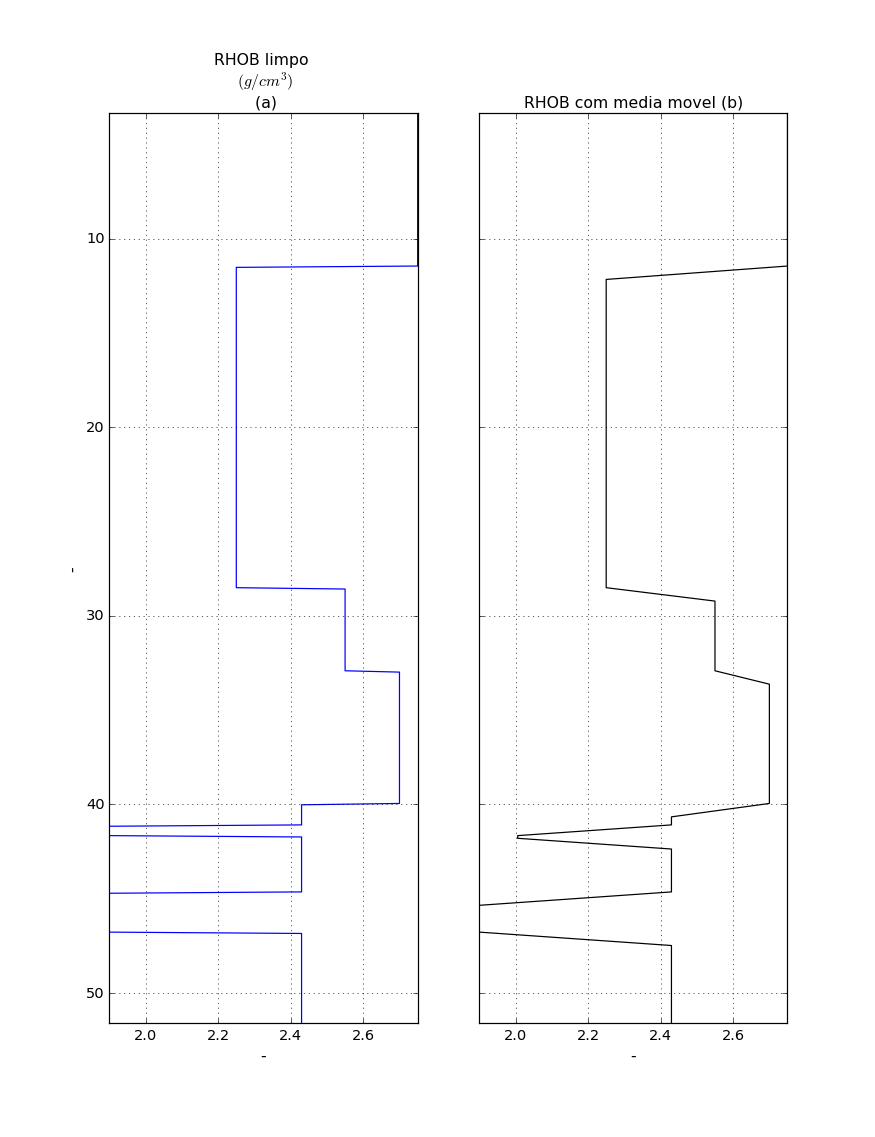

In [29]:
padrao={'comprimento':10,
            'altura':13
        #'titulo_geral': 'Well C1'
         }

figure2 = plm2(2, padrao)
#figure2.plot_l2(0,cod,prof, codigo,{'titulo':'True \n Lithology \n (a)', 'descricao_y':'Depth(m)'})

figure2.plot_s(0,np.array(RHOmb),prof,{'titulo':'RHOB limpo \n $(g/cm^{3})$ \n (a)','cor':'b'})
figure2.plot_s(1,rhomb,prof,{'titulo':'RHOB com media movel (b)', 'cor':'k'})

#figure2.plot_s(2,np.array(GRmb),prof,{'titulo':'GR limpo \n $(g/cm^{3})$ \n (b)','cor':'b'})
#figure2.plot_s(3,grmb,prof,{'titulo':'GR noise + media movel (d)', 'cor':'k'})

#figure2.plot_s(4,np.log(Rmb),prof,{'titulo':'RES limpo \n $(g/cm^{3})$ \n (b)','cor':'b'})
#figure2.plot_s(5,np.log(ildmb),prof,{'titulo':'RES noise + media movel (d)', 'cor':'k'})

#figure2.plot_s(6,np.array(Smb),prof,{'titulo':'DT limpo \n $(g/cm^{3})$ \n (b)','cor':'b'})
#figure2.plot_s(7,dtmb,prof,{'titulo':'DT noise + media movel (d)', 'cor':'k'})

#plt.savefig('../final/rhob_mm_p2.2.png', dpi=300, bbox_inches = 'tight', transparent = True)

In [30]:
mu = 0.0 # media 0.0
std = 0.1 # 2% de ruido 
a = np.zeros(len(rhomb))
for i in range(len(rhomb)):
    a[i] = random.normalvariate(mu, std)

In [31]:
mu = 0.0 # media 0.0
std = 6.2 # 2% de ruido 
b = np.zeros(len(grmb))
for i in range(len(grmb)):
    b[i] = random.normalvariate(mu, std)

In [32]:
mu = 0.0 # media 0.0
std = 2.4 # 2% de ruido 
c = np.zeros(len(ildmb))
for i in range(len(ildmb)):
    c[i] = random.normalvariate(mu, std)

In [33]:
mu = 0.0 # media 0.0
std = 15.5 # 2% de ruido 
d = np.zeros(len(dtmb))
for i in range(len(dtmb)):
    d[i] = random.normalvariate(mu, std)

In [34]:
# adicao de ruido aos dados:
rhomb += a
grmb += b
ildmb += c
dtmb += d


<IPython.core.display.Javascript object>


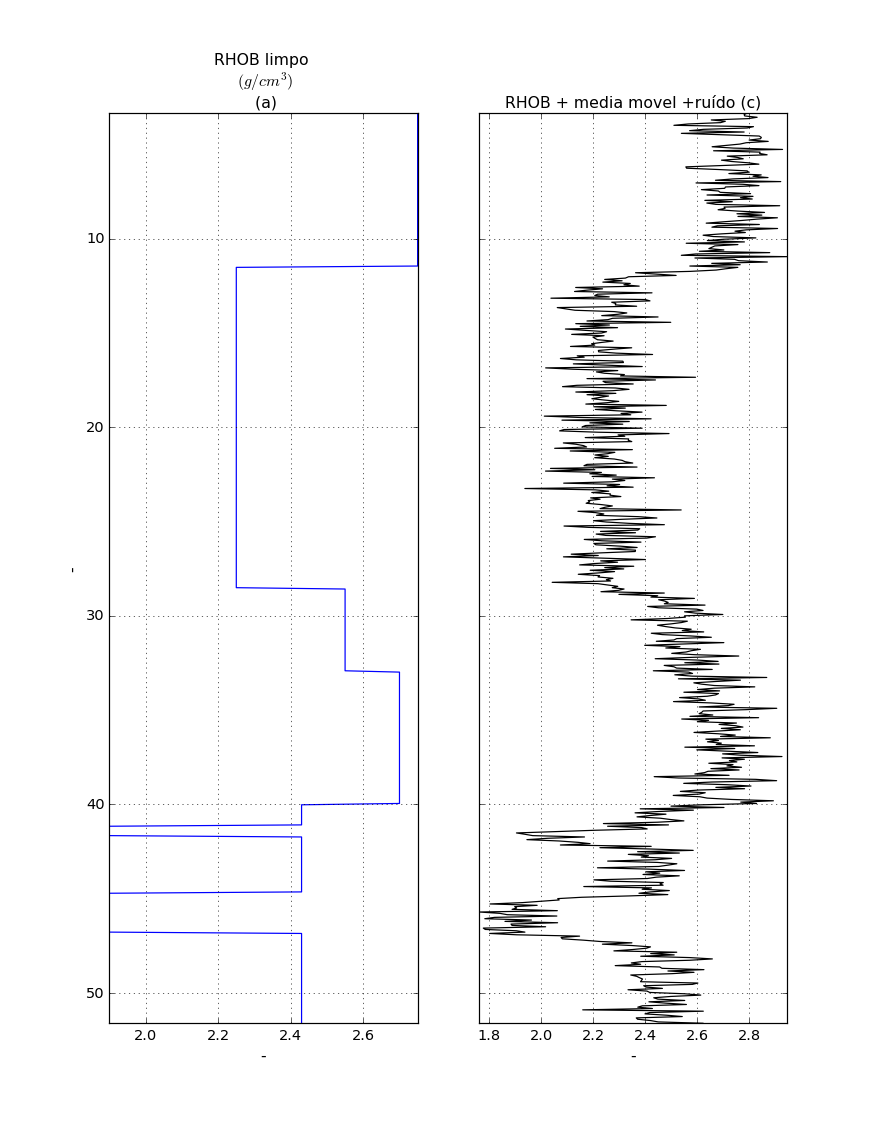

In [35]:
padrao={'comprimento':10,
            'altura':13
        #'titulo_geral': 'Well C1'
         }

figure2 = plm2(2, padrao)
#figure2.plot_l2(0,cod,prof, codigo,{'titulo':'True \n Lithology \n (a)', 'descricao_y':'Depth(m)'})

figure2.plot_s(0,np.array(RHOmb),prof,{'titulo':'RHOB limpo \n $(g/cm^{3})$ \n (a)','cor':'b'})
figure2.plot_s(1,rhomb,prof,{'titulo':'RHOB + media movel +ruído (c)', 'cor':'k'})

#figure2.plot_s(2,np.array(GRmb),prof,{'titulo':'GR limpo \n $(g/cm^{3})$ \n (b)','cor':'b'})
#figure2.plot_s(3,grmb,prof,{'titulo':'GR noise + media movel (d)', 'cor':'k'})

#figure2.plot_s(4,Rmb,prof,{'titulo':'RES limpo \n $(g/cm^{3})$ \n (b)','cor':'b'})
#figure2.plot_s(5,ildmb,prof,{'titulo':'RES noise + media movel (d)', 'cor':'k'})

#figure2.plot_s(6,np.array(Smb),prof,{'titulo':'DT limpo \n $(g/cm^{3})$ \n (b)','cor':'b'})
#figure2.plot_s(7,dtmb,prof,{'titulo':'DT noise + media movel (d)', 'cor':'k'})

#plt.savefig('../final/rhob_mm_noise_p2.png', dpi=300, bbox_inches = 'tight', transparent = True)


# Criação do Dataframe com todos os dados:
d = {'prof':prof,'cod_rock': codrock, 
     'rhob': rhomb,'gr': grmb, 'res': ildmb, 'dt': dtmb}

df = pd.DataFrame(d)
df.to_csv('../saida/data_codrock_09-05.txt', index=False, sep= ' ', float_format='%.2e')

### Plot do perfil litológico + propriedades

ordem= [0, 1, 2, 3, 4, 5]


<IPython.core.display.Javascript object>


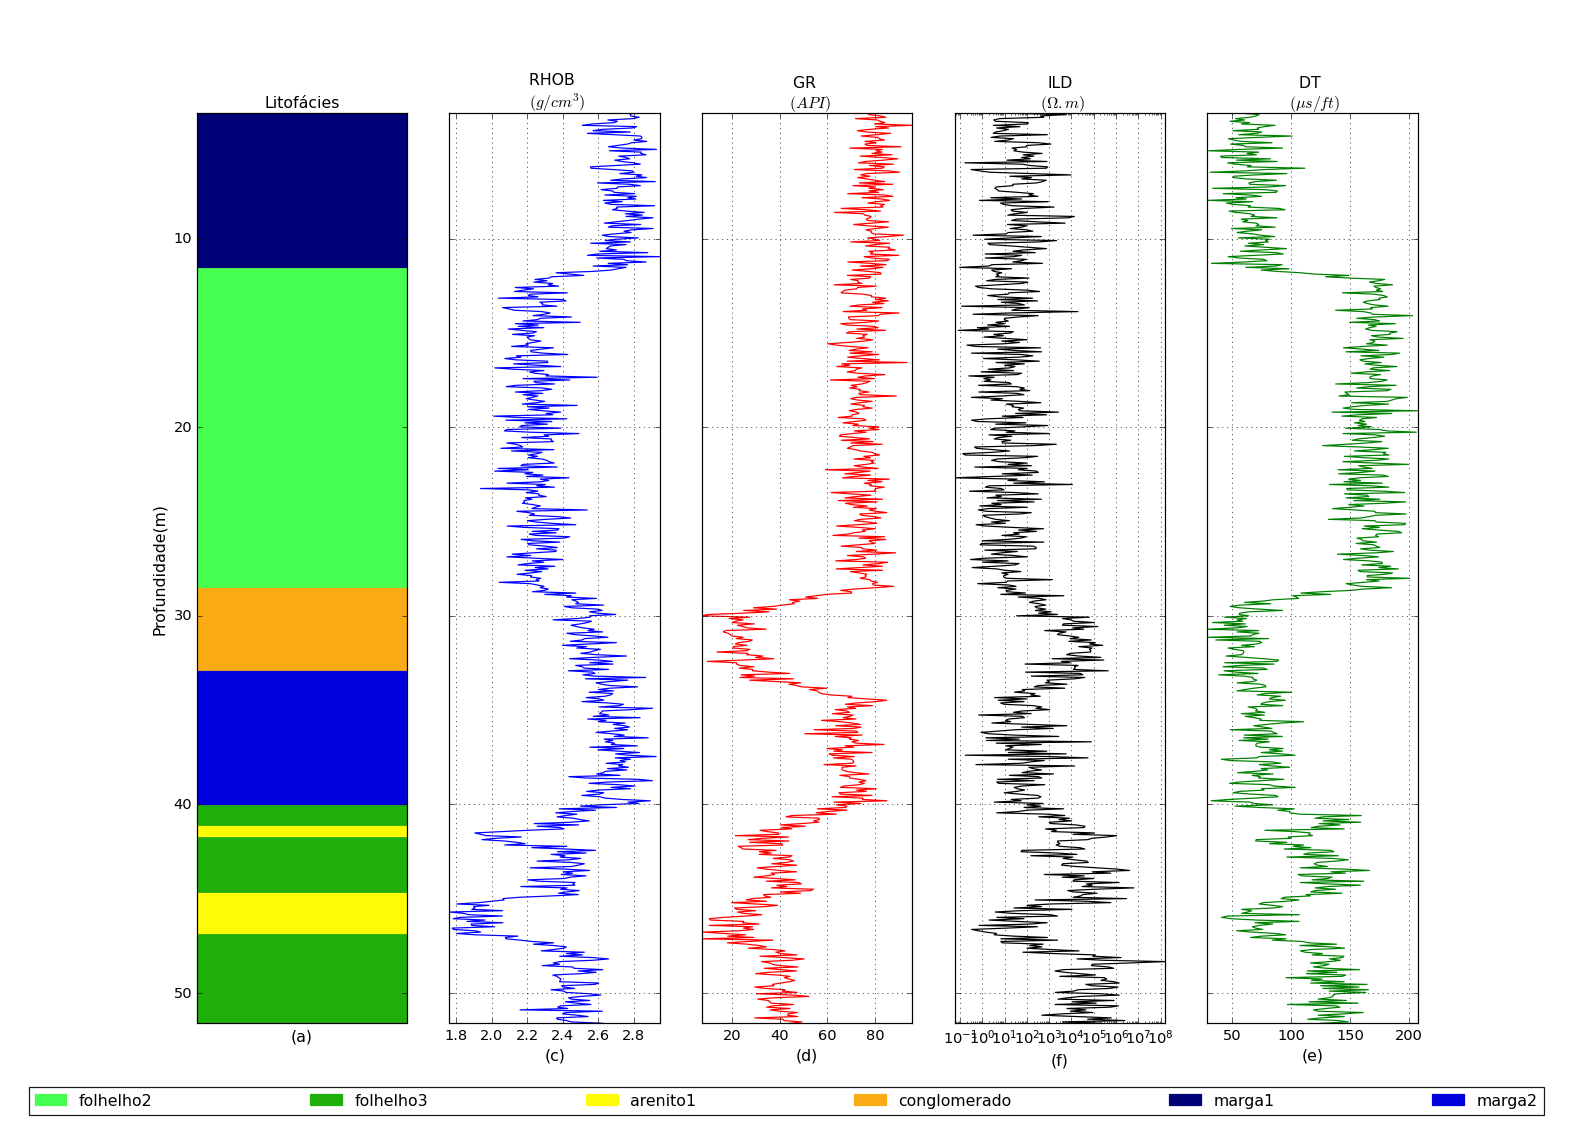

In [37]:

def order(x):
    """Cria uma lista começando do zero com o mesmo tamanho do dicionario"""
    r= [0]
    for i in range(x-1):
        i=i+1
        r.append(i)
    return r
    

print('ordem=',order(len(dic)))


# Gerando a imagem do poço

padrao={'comprimento':18,
            'altura':13,
#        'titulo_geral': 'Modelagem de perfis - 10%'
         }

figure2 = plm2(5, padrao) # Alterar pra 7 futuramente

# d = {'prof':prof,'cod_rock': codrock, 'rhob': RHOmb,'gr': GRmb, 'res': Rmb, 'dt': Smb}

figure2.plot_l2(0,np.array(df.cod_rock),np.array(df.prof), dic,{'titulo':'Litofácies',
                                                                'descricao_y':'Profundidade(m)','descricao_x':'(a)'})

figure2.plot_s(1,rhomb,prof,
               {'titulo':'RHOB \n $(g/cm^{3})$','cor':'b','descricao_x':'(c)'})

figure2.plot_s(2,grmb,prof,
               {'titulo':'GR \n $(API)$','cor':'r','descricao_x':'(d)'})

figure2.plog_s(3,np.exp(ildmb),prof,   ############### plog_s = escala em logarítmo no gráfico
               {'titulo':'ILD\n $(\Omega.m) $', 'cor':'k','descricao_x':'(f)'})

figure2.plot_s(4,dtmb,prof,
               {'titulo':'DT \n $(\mu s/ft)$','cor':'g','descricao_x':'(e)'})

figure2.legenda({'ancoragem':(-0.8, 0.08, 7.2, -0.15),'colunas':6,'ordem':order(len(dic)) })

#figure2.legenda({'ancoragem':(-0.25, 0.1, 6.0, -0.15),'colunas':3,'ordem':order(len(dic)) })

plt.savefig('figures/perfis_class.png', dpi=300, bbox_inches = 'tight', transparent = True)


In [38]:
coresp2 =  [0.0]*np.size(df.rhob,0)
#cores = []
#prof = []*np.size(mb,0) #cria um vetor vazio

for i in range(len(df.rhob)):
    
    if codrock[i] == 0:     
        coresp2[i] = dic[0][0]
        
    if codrock[i] == 1:     
        coresp2[i] = dic[1][0]
        
    if codrock[i] == 2:     
        coresp2[i] = dic[2][0]  
        
    if codrock[i] == 3:     
        coresp2[i] = dic[3][0]  
        
    if codrock[i] == 4:
        coresp2[i] = dic[4][0]   
        
    if codrock[i] == 5:
        coresp2[i] = dic[5][0]   
        
    if codrock[i] == 6:
        coresp2[i] = dic[6][0]   
        
    if codrock[i] == 7:
        coresp2[i] = dic[7][0] 
        
    if codrock[i] == 8:
        coresp2[i] = dic[8][0] 

In [39]:
coresp2

['#000078',
 '#000078',
 '#000078',
 '#000078',
 '#000078',
 '#000078',
 '#000078',
 '#000078',
 '#000078',
 '#000078',
 '#000078',
 '#000078',
 '#000078',
 '#000078',
 '#000078',
 '#000078',
 '#000078',
 '#000078',
 '#000078',
 '#000078',
 '#000078',
 '#000078',
 '#000078',
 '#000078',
 '#000078',
 '#000078',
 '#000078',
 '#000078',
 '#000078',
 '#000078',
 '#000078',
 '#000078',
 '#000078',
 '#000078',
 '#000078',
 '#000078',
 '#000078',
 '#000078',
 '#000078',
 '#000078',
 '#000078',
 '#000078',
 '#000078',
 '#000078',
 '#000078',
 '#000078',
 '#000078',
 '#000078',
 '#000078',
 '#000078',
 '#000078',
 '#000078',
 '#000078',
 '#000078',
 '#000078',
 '#000078',
 '#000078',
 '#000078',
 '#000078',
 '#000078',
 '#000078',
 '#000078',
 '#000078',
 '#000078',
 '#000078',
 '#000078',
 '#000078',
 '#000078',
 '#000078',
 '#000078',
 '#000078',
 '#000078',
 '#000078',
 '#000078',
 '#000078',
 '#000078',
 '#000078',
 '#000078',
 '#000078',
 '#000078',
 '#000078',
 '#000078',
 '#000078',
 '#0

<IPython.core.display.Javascript object>


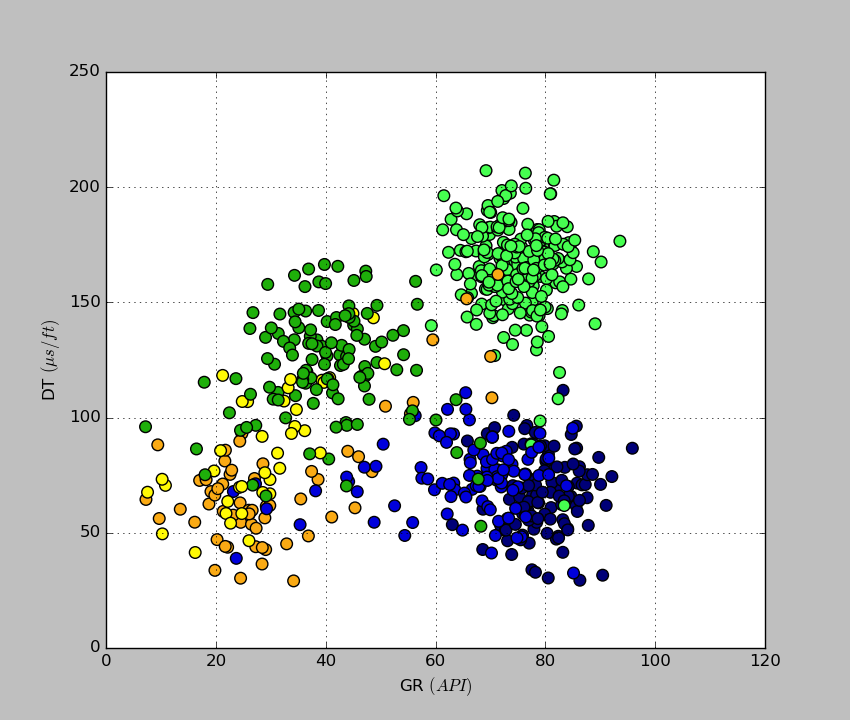

In [45]:
import matplotlib.patches as mpatches

plt.close('all')
plt.figure(figsize=(8.5,7.2))

plt.scatter(np.array(grmb), np.array(dtmb), c=coresp2
            , s=70, alpha=1.0) 

#plt.legend(bbox_to_anchor=(0.74, 0.58))

plt.xlabel('GR $(API)$', fontsize = 12)
plt.ylabel('DT $(\mu s/ft)$', fontsize = 12)

plt.grid(True)
plt.savefig('figures/GRxDT_p2originaldisper.png', dpi=300,  bbox_inches = 'tight', transparent = True)
#plt.savefig('../final/GRxDT_p2originaldisper_09-05.pdf', dpi=300,  bbox_inches = 'tight', transparent = True)

#'RHOMB $(g/cm^{3})$',[-1,1]]
#dado_info['y'] = ['GR $(API)$',[-1,1]]
#dado_info['z'] = ['ILD $(\Omega.m)$',[-1,1]]
#dado_info['w'] = ['DT $(\mu s/ft)$',[-1,1]]

<IPython.core.display.Javascript object>


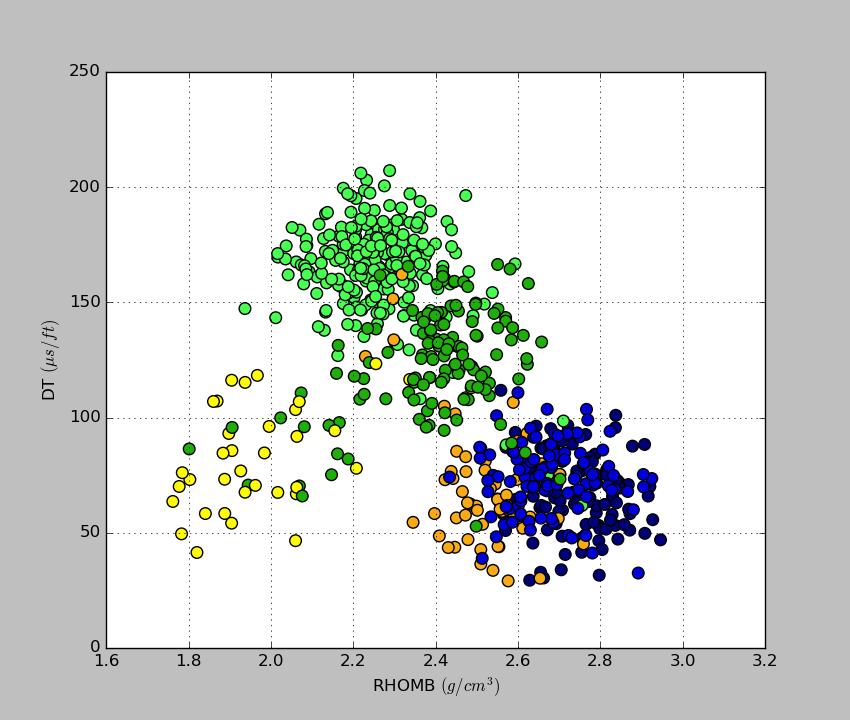

In [46]:
import matplotlib.patches as mpatches

plt.close('all')
plt.figure(figsize=(8.5,7.2))

plt.scatter(np.array(rhomb), np.array(dtmb), c=coresp2
            , s=70, alpha=1.0) 

#plt.legend(bbox_to_anchor=(0.74, 0.58))

plt.xlabel('RHOMB $(g/cm^{3})$', fontsize = 12)
plt.ylabel('DT $(\mu s/ft)$', fontsize = 12)

plt.grid(True)
plt.savefig('figures/RHOxDT_p2originaldisper.png', dpi=300,  bbox_inches = 'tight', transparent = True)
#plt.savefig('../final/RHOxDT_p2originaldisper_09-05.pdf', dpi=300,  bbox_inches = 'tight', transparent = True)

<IPython.core.display.Javascript object>


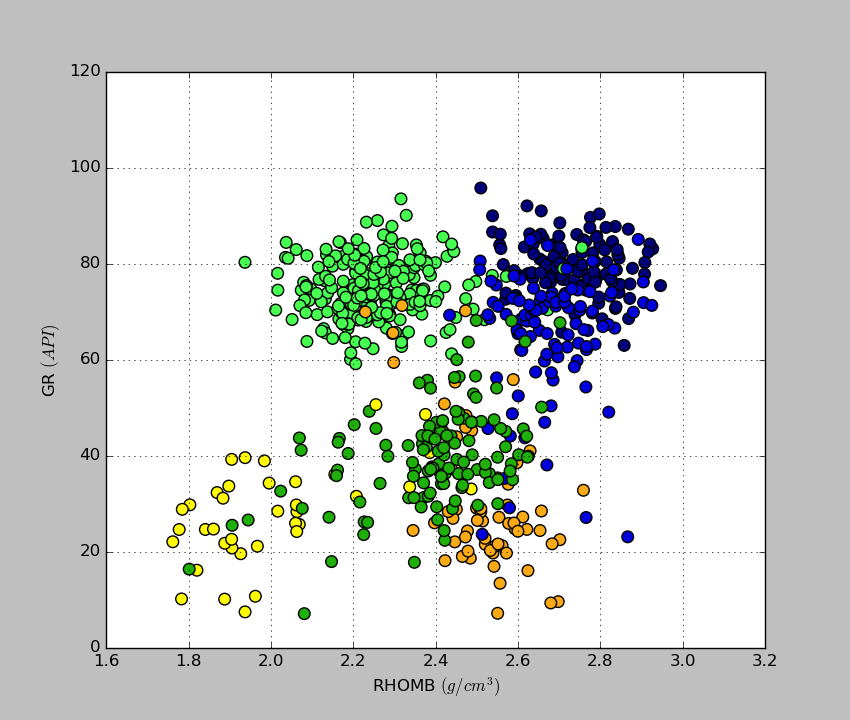

In [47]:
import matplotlib.patches as mpatches

plt.close('all')
plt.figure(figsize=(8.5,7.2))

plt.scatter(np.array(rhomb), np.array(grmb), c=coresp2
            , s=70, alpha=1.0) 

#plt.legend(bbox_to_anchor=(0.74, 0.58))

plt.xlabel('RHOMB $(g/cm^{3})$', fontsize = 12)
plt.ylabel('GR $(API)$', fontsize = 12)

plt.grid(True)
plt.savefig('figures/RHOxGR_p2originaldisper.png', dpi=300,  bbox_inches = 'tight', transparent = True)
#plt.savefig('../final/RHOxGR_p2originaldisper_09-05.pdf', dpi=300,  bbox_inches = 'tight', transparent = True)

<IPython.core.display.Javascript object>


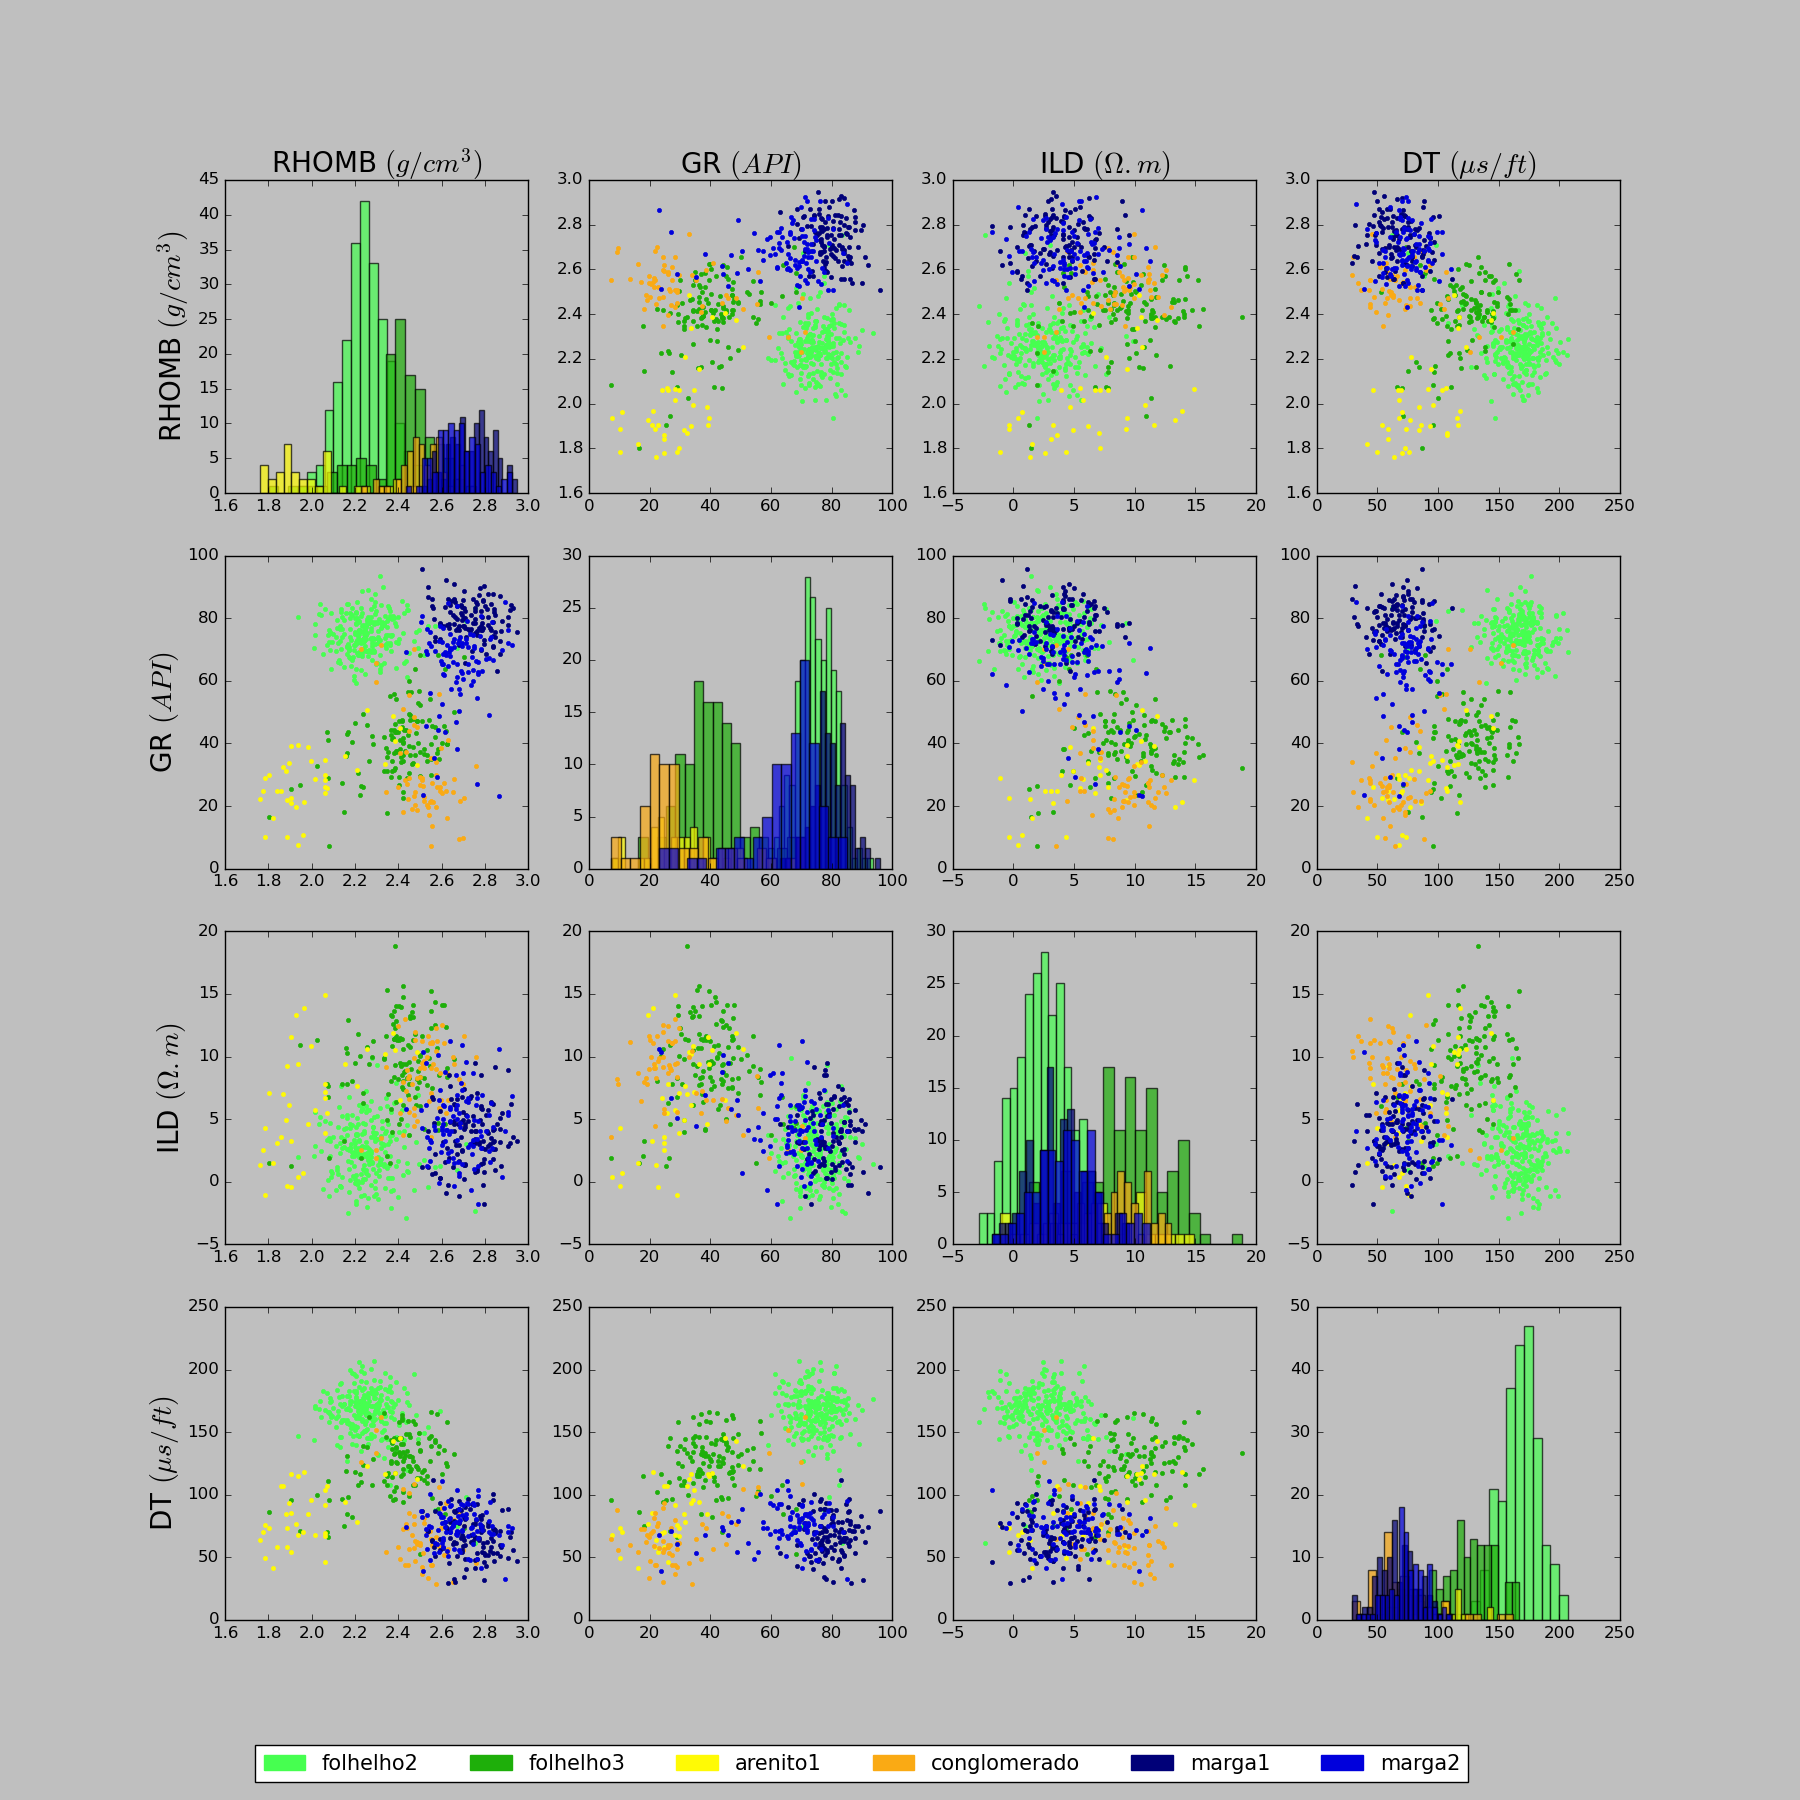

In [44]:
import matplotlib.patches as mpatches
import disper as dis

########################################### Plot da dispersão para ruído de 5% ###################################### 

dado = {}
dado['x'] = rhomb
dado['y'] = grmb
dado['z'] = ildmb
dado['w'] = dtmb

dado_info = {}
dado_info['x'] = ['RHOMB $(g/cm^{3})$',[-1,1]]
dado_info['y'] = ['GR $(API)$',[-1,1]]
dado_info['z'] = ['ILD $(\Omega.m)$',[-1,1]]
dado_info['w'] = ['DT $(\mu s/ft)$',[-1,1]]

nova_legenda = {
    'fonte':15,
    'colunas':6
}

a = {'comprimento':10,
            'altura':10,
    'titulo_fonte':20,
    'legenda':nova_legenda,
}


nova_legenda = {}

dis.analise_dispersao(dado, dado_info, codrock, dic, posicao = [1,0,1,0,4],
                  multi_histogram = [20,0.7], padrao_usuario = a)

#plt.savefig('../saida/disper_p2_09-05.pdf', dpi=300, bbox_inches = 'tight', transparent = False)

### Arq3 = poço para classificação (gabarito)

In [48]:
d2 = {'cod_rock': codrock, 'Litologia': lito,'prof':prof, 'dens': rhomb,
      'gama': grmb,'res': ildmb, 'vel': dtmb}

df2 = pd.DataFrame(d2)
df2.to_csv('syntetic_well_logging/arq_class_gab.txt', index=False, sep= ' ', float_format='%.2e') # 5 litologias

### Arq4 = poço para classificação (usar no SOM)

In [49]:
# codrock entra no gabarito:

d2 = {'prof':prof, 'dens': rhomb,
      'gama': grmb,'res': ildmb,
      'vel': dtmb}

df2 = pd.DataFrame(d2)
df2.to_csv('syntetic_well_logging/arq_class.txt', index=False, sep= ' ', float_format='%.2e') # 5 litologias

  # FIM